# Bivariate analysis

## Simple and efficient contingency table with Cramer's V & standardized residuals



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import scipy.stats as stats
import statsmodels.api as sm

df = pd.DataFrame(
    {
        "var1": [str(i // 40) for i in range(120)],
        "var2": [str(i // 30) for i in range(120)],
    }
)


In [4]:
def select_dtype(df: pl.DataFrame, dtype: pl.DataType) -> pl.DataFrame:
    """
    Select columns with a specific data type using Polars.
    """
    # Select "i8"  dtype columns
    col_dtypes = {df.columns[i]: dtype for i, dtype in enumerate(df.dtypes)}
    return df.select(
        [pl.col(col) for col, dtype in col_dtypes.items() if dtype == pl.Int8]
    )


def get_cramer_v(dataframe: pd.DataFrame, col1: str, col2: str) -> float:
    crosstab = pd.crosstab(
        dataframe[col1].astype(str),
        dataframe[col2].astype(str),
    )

    crosstab_np = crosstab.to_numpy()
    X2 = stats.chi2_contingency(crosstab_np, correction=False)[0]
    N = crosstab_np.sum()
    min_dim = min(crosstab_np.shape) - 1
    cramer_V = np.sqrt(X2 / (N * min_dim))
    return float(cramer_V)


def plot_contingency_table(dataframe: pd.DataFrame, col1: str, col2: str):
    """
    Plot a contingency table with the given columns.
    """
    crosstab = pd.crosstab(
        dataframe[col1].astype(str),
        dataframe[col2].astype(str),
    )
    cramer_v = get_cramer_v(dataframe, col1, col2)

    contingency_table = sm.stats.Table(crosstab)
    standard_resitudals = contingency_table.standardized_resids

    plt.figure(figsize=(10, 6))
    im = plt.imshow(standard_resitudals, cmap="RdBu", vmin=-4, vmax=4)

    for i in range(len(standard_resitudals.index)):
        for j in range(len(standard_resitudals.columns)):
            _ = plt.text(
                j, i, f"{crosstab.to_numpy()[i, j]:.0f}", ha="center", va="center"
            )

    plt.xticks(
        range(len(standard_resitudals.columns)),
        standard_resitudals.columns,
        rotation=45,
        ha="right",
    )
    plt.yticks(range(len(standard_resitudals.index)), standard_resitudals.index)
    plt.title(f"Contingency Table: \n {col1} / {col2} \n Cramer's V: {cramer_v:.2f}")
    plt.xlabel(col2)
    plt.ylabel(col1)
    plt.colorbar(im, label="Standardized Residuals")
    plt.tight_layout()
    plt.show()


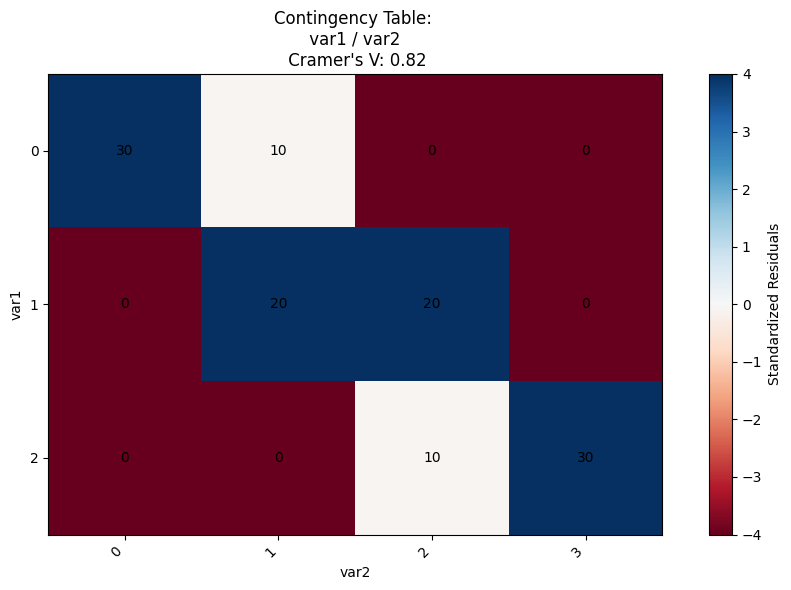

In [5]:
plot_contingency_table(
    df,
    col1="var1",
    col2="var2",
)


# Xi correlation

This type of correlation can be used to measure non-linear and non-monotonic relationships.

In [6]:
import numpy as np
from scipy.stats import rankdata, norm
from typing import Union


def xicor(
    x: np.ndarray,
    y: np.ndarray,
    ties: Union[str, bool] = "auto",
) -> tuple[float, float]:
    """Calculate the correlation coefficient and p-value using the xicor method.
    See: https://arxiv.org/abs/1909.10140

    Args:
        x: First array of numeric values
        y: Second array of numeric values
        ties: Strategy for handling ties. "auto" detects ties automatically,
             or boolean to explicitly enable/disable tie handling

    Returns:
        Tuple containing:
        - correlation statistic (float between -1 and 1)
        - p-value for the correlation test

    Raises:
        ValueError: If input arrays are empty or contain non-numeric values
        IndexError: If input arrays have different lengths
        TypeError: If ties parameter is invalid type
    """
    # Validate and prepare input arrays
    if not len(x) or not len(y):
        raise ValueError("Input arrays cannot be empty")

    x = np.asarray(x, dtype=np.float64).flatten()
    y = np.asarray(y, dtype=np.float64).flatten()
    n = len(y)

    if len(x) != n:
        raise IndexError(f"x, y length mismatch: {len(x)}, {len(y)}")

    # Handle ties parameter
    if ties == "auto":
        ties = len(np.unique(y)) < n
    elif not isinstance(ties, bool):
        raise ValueError(
            f'Expected ties to be "auto" or boolean, '
            f"got {ties} ({type(ties)}) instead"
        )

    # Sort y values based on x order and calculate ranks
    y_sorted = y[np.argsort(x)]
    ranks = rankdata(y_sorted, method="ordinal")
    nominator = np.sum(np.abs(np.diff(ranks)))

    # Calculate denominator based on ties handling
    if ties:
        rank_max = rankdata(y_sorted, method="max")
        denominator = 2 * np.sum(rank_max * (n - rank_max))
        nominator *= n
    else:
        denominator = np.power(n, 2) - 1
        nominator *= 3

    # Calculate final statistics
    statistic = 1 - nominator / denominator  # upper bound is (n - 2) / (n + 1)
    p_value = norm.sf(statistic, scale=2 / 5 / np.sqrt(n))

    return statistic, p_value


In [78]:
import plotly.express as px
from scipy.stats import pearsonr

nb_points = 100
x = np.linspace(-10, 10, nb_points)

funcs = {
    "X, high dispersion": x + np.random.normal(0, 20, nb_points),
    "X, low dispersion": x + np.random.normal(0, 5, nb_points),
    "X²": np.pow(x, 2) + np.random.normal(0, 10, nb_points),
    "X4": np.pow(x / 4, 4)
    - 0.075 * np.pow(2 * x, 2)
    + np.random.normal(0, 1.5, nb_points),
}

for func, y in funcs.items():
    pearson_correlation, p_value = pearsonr(x, y)
    xi_correlation, p_value = xicor(x, y)

    (
        px.scatter(
            x=x,
            y=y,
            title=f"<b>{func}<br></b>Pearson correlation: {pearson_correlation:.2f}<br>Xi correlation: {xi_correlation:.2f}",
        )
        .update_layout(title_x=0.5)
        .show()
    )
